# Implementation of the Simple Imaging Polynomials (SIP) Convention for Representing Geometric Distortion

We implement the SIP algorithm for representing non-linear geometric distortion of a linear coordinate transformation ([link](https://irsa.ipac.caltech.edu/data/SPITZER/docs/files/spitzer/shupeADASS.pdf)). SIP transforms a $2D$ coordiante $\begin{pmatrix}
u\\
v
\end{pmatrix}$ to another coordiante $\begin{pmatrix}
x\\
y
\end{pmatrix}$ using the the transformation

\begin{equation}
\begin{pmatrix}
x\\
y
\end{pmatrix}
=
\begin{pmatrix}
\mathrm{CD1\_1} & \mathrm{CD1\_2} \\
\mathrm{CD2\_1} & \mathrm{CD2\_2}
\end{pmatrix}
\begin{pmatrix}
u + f(u, v)\\
v + g(u, v)
\end{pmatrix}
\end{equation}.

$CD$ is a know tranformation matrix. $f$ and $g$ are known polynomials defined as

\begin{equation}
f(u, v) = \sum_{p,q} A\_p\_q u^p v^q, \quad p+q \le \textrm{A_Order}
\end{equation}

and

\begin{equation}
g(u, v) = \sum_{p,q} B\_p\_q u^p v^q, \quad p+q \le \textrm{B_Order}
\end{equation}.

Apply the inverse of the matrix multiplication, we have $U$ and $V$ defined as power series of $u$ and $v$.

\begin{equation}
\begin{pmatrix}
U\\
V
\end{pmatrix}
=
\mathrm{CD}^{-1}
\begin{pmatrix}
x\\
y
\end{pmatrix}
=
\begin{pmatrix}
u + f(u, v)\\
v + g(u, v)
\end{pmatrix}
\end{equation}

The behavior of $U$ and $V$ is smooth in $u$ and $v$. We expect the inverse is also smooth. Thus, we can expand $u$ and $v$ as power series of $U$ and $V$.

\begin{align}
u = U + F(U, V) = U + \sum_{p,q} AP\_p\_q U^p V^q, \quad p+q \le \textrm{AP_Order}
\end{align}

\begin{align}
v = V + G(U, V) = V + \sum_{p,q} BP\_p\_q U^p V^q, \quad p+q \le \textrm{BP_Order}
\end{align}

Coefficients $AP\_p\_q$ and $BP\_p\_q$ can be fitted by comparing the residual between true $u$, $v$ and reconstructed $u$, $v$ from $U$, $V$. True $u$, $v$ are sampled from the grid of the image.

In [2]:
import numpy as np
from scipy.optimize import least_squares
import matplotlib.pyplot as plt

In [14]:
def sample_grid(u_max, v_max, npoints_in_u_axis, npoints_in_v_axis):
    """Sample pixel points from a grid.
    """
    u_coords = np.linspace(0, u_max, npoints_in_u_axis)
    v_coords = np.linspace(0, v_max, npoints_in_v_axis)
    u, v = np.meshgrid(u_coords, v_coords)

    return u, v

def polynomial_sum(u, v, coef):
    """Evaluate the polynomial sum.
    """
    order = coef.shape[0] - 1
    result = 0
    for i in range(0, order+1):
        for j in range(0, order - i + 1):
            result += coef[i][j] * (u**i) * (v**j)
    return result

def compute_uv_UV(width, height, A, B, AP_order, BP_order, npoints_in_u_axis, npoints_in_v_axis):
    """Compute u, v, U, V.
    """
    u, v = sample_grid(width-1, height-1, npoints_in_u_axis, npoints_in_v_axis)
    f_uv = polynomial_sum(u, v, A)
    g_uv = polynomial_sum(u, v, B)

    U = u + f_uv
    V = v + g_uv

    return u, v, U, V


def residuals(params, u, v, U, V, AP_order, BP_order):
    """Residuals for the least squares optimization.
    """
    AP = params[:(AP_order+1)**2].reshape((AP_order+1, AP_order+1))
    BP = params[(AP_order+1)**2:].reshape((BP_order+1, BP_order+1))

    F_UV = polynomial_sum(U, V, AP)
    G_UV = polynomial_sum(U, V, BP)

    res_u = u - (U + F_UV)
    res_v = v - (V + G_UV)

    return np.hstack((res_u.flatten(), res_v.flatten()))

def fit_AP(width, height, A, B, AP_order, BP_order, npoints_in_u_axis=30, npoints_in_v_axis=30):
    """Fit sip AP coefficients.
    """

    # get A order, B order
    A_order = A.shape[0] - 1
    B_order = B.shape[0] - 1

    # compute grids
    u, v, U, V = compute_uv_UV(width, height, A, B, AP_order, BP_order, npoints_in_u_axis, npoints_in_v_axis)

    # use 0 guess
    AP_initial = np.zeros((AP_order+1, AP_order+1))
    BP_initial = np.zeros((BP_order+1, BP_order+1))
    initial_guess = np.hstack((AP_initial.flatten(), BP_initial.flatten()))

    # perform least square fitting
    result = least_squares(residuals, initial_guess, args=(u, v, U, V, AP_order, BP_order))

    fitted_params = result.x
    AP_fitted = fitted_params[:(AP_order+1)**2].reshape((AP_order+1, AP_order+1))
    BP_fitted = fitted_params[(AP_order+1)**2:].reshape((BP_order+1, BP_order+1))

    return AP_fitted, BP_fitted


In [23]:
image = np.random.rand(2000, 2000)

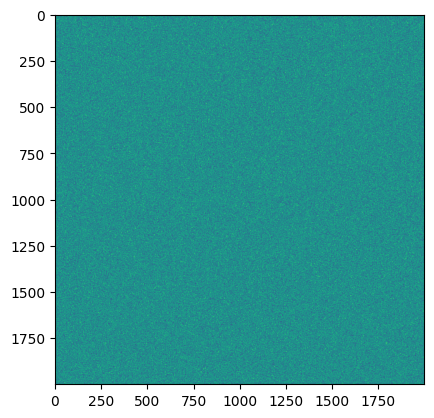

In [24]:
plt.imshow(image)

In [25]:
width, height = image.shape

In [26]:
# generate CD matrix

rotation_rad = np.pi / 4

CD = np.array([[np.cos(rotation_rad), -np.sin(rotation_rad)],
              [np.sin(rotation_rad),  np.cos(rotation_rad)]])

CD_inverse = 1 / (CD[0][0] * CD[1][1] - CD[0][1] * CD[1][0]) * np.array([[CD[1][1], -CD[0][1]],
                                                                        [-CD[1][0], CD[0][0]]])

In [27]:
# setup A, B matrix and AP order, BP order
A = np.array(
    [
        [1.96E-05, -1.12E-05],
        [-1.12E-05, 2.23E-05]
    ]
)

B = np.array(
    [
        [ 9.87E-05, 2.44E-05],
        [2.44E-05, 2.25E-05]
    ]
)

# use 2nd order expansion
AP_order = 2
BP_order = 2

In [28]:
AP_fitted, BP_fitted = fit_AP(width, height, A, B, AP_order, BP_order)

In [29]:
print("fitted AP coefficients:\n", AP_fitted)
print("\n")
print("fitted BP coefficients:\n", BP_fitted)


fitted AP coefficients:
 [[-1.96013249e-05  1.11998522e-05  1.81849557e-20]
 [ 1.11998522e-05  1.72600590e-20  1.85590317e-06]
 [ 3.03910453e-20  0.00000000e+00  0.00000000e+00]]


fitted BP coefficients:
 [[-9.86971135e-05 -2.43996779e-05 -1.40773012e-21]
 [-2.43996779e-05  1.76855125e-21  0.00000000e+00]
 [-8.90499687e-21  0.00000000e+00  0.00000000e+00]]


In [30]:
# compute residuals for comparison
fitted_params = np.hstack((AP_fitted.flatten(), BP_fitted.flatten()))
u, v, U, V = compute_uv_UV(width, height, A, B, AP_order, BP_order, npoints_in_u_axis=2000, npoints_in_v_axis=2000)
res = residuals(fitted_params, u, v, U, V, AP_order, BP_order)

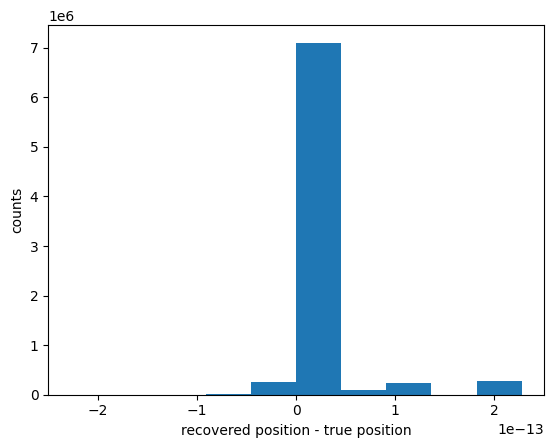

In [31]:
plt.hist(res);
plt.xlabel("recovered position - true position");
plt.ylabel("counts");